# **Import Packages**

In [1]:
import os
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
import io
from PIL import Image
from warnings import filterwarnings

# **Data Loading**

In [2]:
x_train = [] # MRI image
y_train = [] # Label of the image
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']


image_size = 256
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-dataset/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        x_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-dataset/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        x_train.append(img)
        y_train.append(i)
        
x_train = np.array(x_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 126.87it/s]


# **Visualization**

**Glioma Tumor:** 
>Originating in the brain or spine's glial cells, gliomas represent 30% of all brain and central nervous system tumors. They are mostly malignant, with symptoms that vary depending on location, frequently resulting in seizures, cognitive impairments, or motor deficits.

**Meningioma Tumor:**
>Meningiomas, arising from the meninges enveloping the brain and spinal cord, are slow-growing tumors. While they typically are asymptomatic, they can cause seizures, cognitive decline, vision disturbances, or motor deficits depending on their location.

**Pituitary Tumor:**
>Pituitary adenomas, mostly benign, occur in the pituitary gland, accounting for 10-25% of intracranial neoplasms. They may cause hormonal imbalances, resulting in a variety of symptoms including headaches, vision changes, or hormonal dysfunctions.


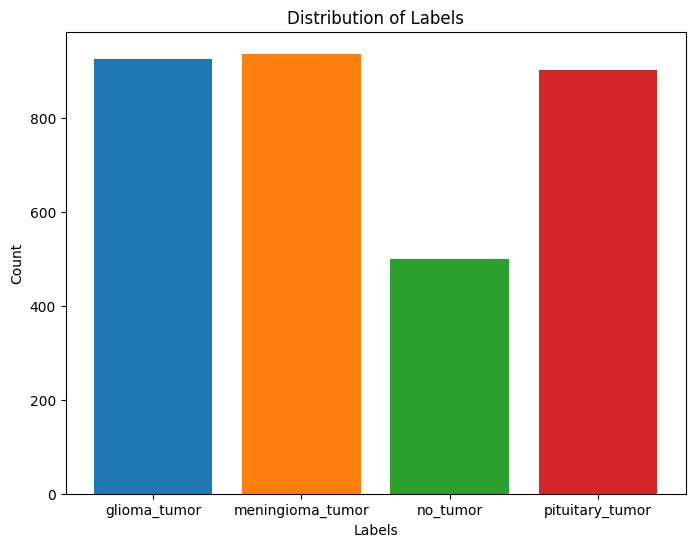

In [3]:
## Create a plot of the label and count of image

# Use a compressed for loop to create a object of the label and the count
label_counts = {label: np.sum(y_train == label) for label in labels}

# Stretch the graph
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

plt.show()

# **Data Preparation**

In [4]:
# Convert the label to one-hot encoding format which converts the categorical data to numeric one
y_train = np.array(pd.get_dummies(y_train))

print(y_train)

[[ True False False False]
 [ True False False False]
 [ True False False False]
 ...
 [False False False  True]
 [False False False  True]
 [False False False  True]]


In [5]:
#Split the dataset into training, testing and validation sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1,random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

print(f'X_train shape: {(x_train).shape}\n'
      f'y_train shape: {(y_train).shape}\n'
      f'X_test shape: {(x_test).shape}\n'
      f'y_test shape: {(y_test).shape}\n'
      f'X_valid shape: {(x_valid).shape}\n'
      f'y_valid shape: {(y_valid).shape}')

X_train shape: (2643, 256, 256, 3)
y_train shape: (2643, 4)
X_test shape: (327, 256, 256, 3)
y_test shape: (327, 4)
X_valid shape: (294, 256, 256, 3)
y_valid shape: (294, 4)


# **Normalization**
Normalization is the process of converting the pixel value from 0-255 to 0-1

In [6]:
# Normalize pixel values of training images to the range [0,1]
x_train = x_train / 255
x_test = x_test / 255
x_valid = x_valid / 255

print(f"Maximum and Minimum pixel value after normalization: {x_train.min()} - {x_train.max()}")

Maximum and Minimum pixel value after normalization: 0.0 - 1.0


# Introduction to Convolution Neural Network

Convolutional Neural Networks (CNNs) are important in Deep Learning, particularly for Computer Vision, as they allow machines to understand and analyze visual data such as images. Neural Networks excel across a wide range of datasets in Machine Learning, including images, audio, and text. CNNs are especially useful for tasks such as image classification.

<p>&nbsp;</p>

In a typical Neural Network architecture, we encounter three key layers:

1. **Input Layer**: This initial layer acts as a gateway for model input. Its neuron count corresponds to the dataset's total features, such as the number of pixels in images.

2. **Hidden Layer**: Data moves from the input layer to the hidden layers, where complex transformations take place. These layers can vary in number and neuron count, allowing the network to capture complex patterns using matrix operations, weight adjustments, biases, and activation functions.

3. **Output Layer**: The output layer receives processed data from the hidden layers and uses functions such as sigmoid or softmax to calculate probability scores for various classes.

<p>&nbsp;</p>

<span style="color:crimson;">Feedforward</span> is the process of feeding data into a neural network model and then sequentially calculating the output from each layer until the final output layer. This step involves applying transformations and activation functions to the input data as it passes through the network.


<span style="color:crimson;">Backpropagation</span>, on the other hand, is the process of changing the model's parameters (weights and biases) by computing the gradients of the loss function with respect to each parameter. These gradients are calculated using the chain rule of calculus and used to adjust the parameters in a way that reduces the loss function. This iterative process enables the model to learn from its mistakes and improves its performance over time.

<p>&nbsp;</p>

In a Convolutional Neural Network, various layers work to process input data, such as images. The Convolutional layer extracts features using filters, the Pooling layer reduces image size to improve efficiency, and the fully connected layer makes predictions. Backpropagation and gradient descent are used by the network to refine its filter parameters and improve its performance.

<p>&nbsp;</p>

*Source: [geeksforgeeks](https://www.geeksforgeeks.org/introduction-convolution-neural-network/)*

# **Model Training**

In [7]:
# Define the model
model = Sequential()

# An Input layer specifying the input shape
model.add(Input(shape=(256, 256, 3)))

# Hidden layer
model.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Conv2D(64, kernel_size=(2,2), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.45))

# Output layer
model.add(Dense(4, activation='softmax'))

# Model Config
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,143,364 (8.18 MB)

 Trainable params: 2,143,364 (8.18 MB)

 Non-trainable params: 0 (0.00 B)

# **Fit the model**

In [8]:
start_time = time.time()

history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=45, verbose=1, batch_size=64)

end_time = time.time()

runtime = end_time - start_time
print("Total runtime:", runtime, "seconds")

Epoch 1/45


I0000 00:00:1724860667.979517      76 service.cc:145] XLA service 0x79bd4c206680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724860667.979578      76 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-08-28 15:57:57.910160: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,128,128]{3,2,1,0}, f32[64,32,128,128]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-08-28 15:57:57.958552: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.048503269s
Trying algorithm eng0{} for conv

 3/42 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.2014 - loss: 1.4948

I0000 00:00:1724860681.530307      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 344ms/step - accuracy: 0.3545 - loss: 1.3539 - val_accuracy: 0.5272 - val_loss: 1.1548
Epoch 2/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.5147 - loss: 1.0956 - val_accuracy: 0.6020 - val_loss: 0.9766
Epoch 3/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6131 - loss: 0.9138 - val_accuracy: 0.6020 - val_loss: 0.8955
Epoch 4/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.6651 - loss: 0.8095 - val_accuracy: 0.6565 - val_loss: 0.7867
Epoch 5/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.7046 - loss: 0.7004 - val_accuracy: 0.6633 - val_loss: 0.7057
Epoch 6/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.7179 - loss: 0.6321 - val_accuracy: 0.7347 - val_loss: 0.6208
Epoch 7/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.7537 - loss: 0.5692 - val_accuracy: 0.7857 - val_loss: 0.5408
Epoch 8/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.8029 - loss: 0.5075 - val_accuracy: 0.7959 - val_loss: 

# **Accuracy and Loss**

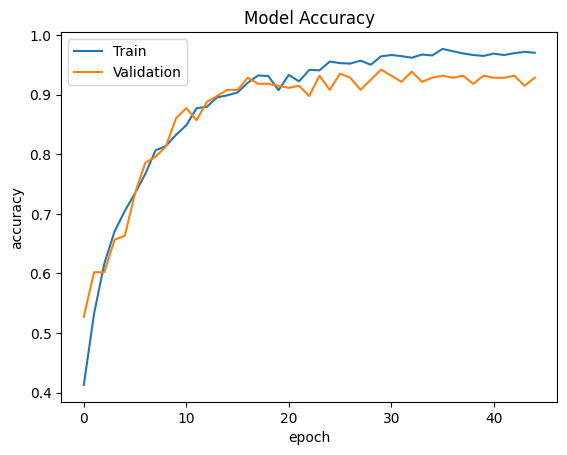

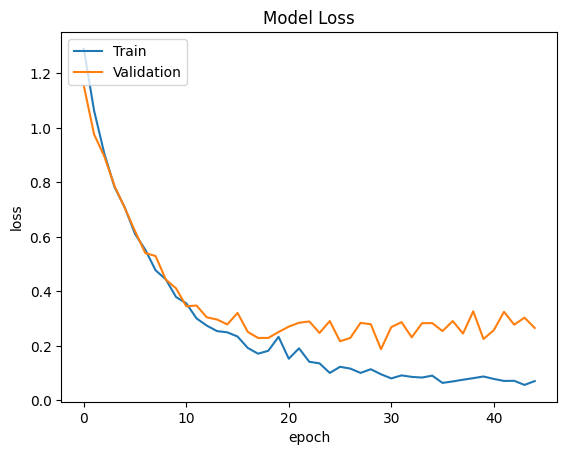

In [17]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **Confusion Matrix**

83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


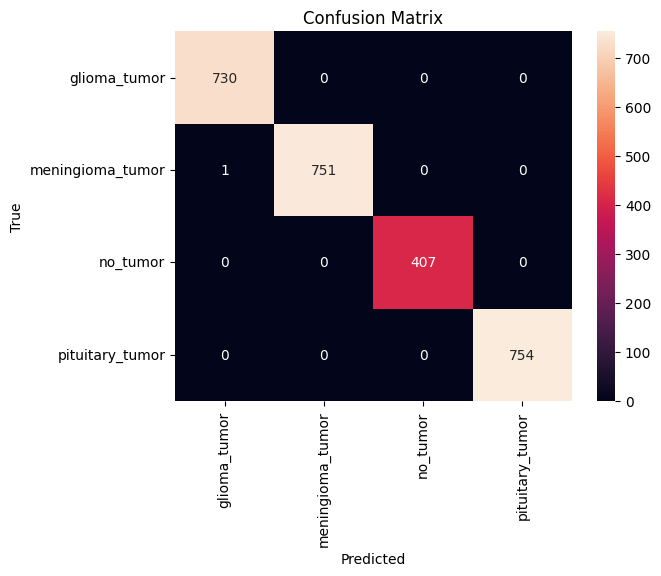

In [9]:
y_true = np.argmax(y_train, axis=1)
y_pred = np.argmax(model.predict(x_train), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


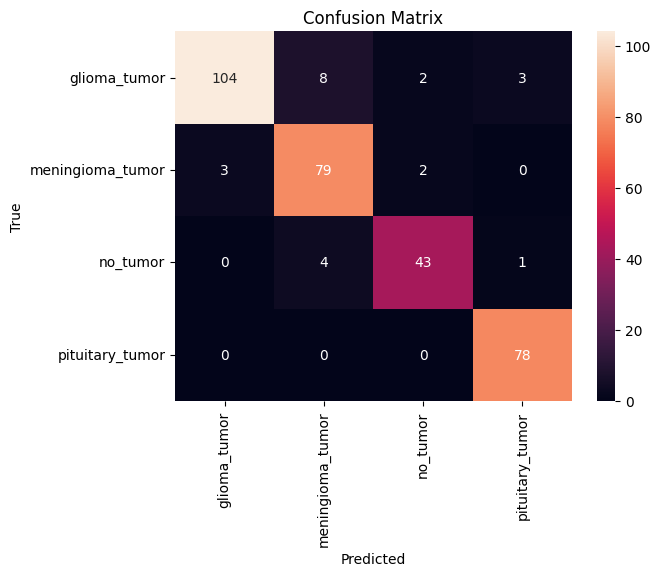

In [10]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(x_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# **Evaluation**

In [11]:
print(classification_report(y_true_test,y_pred_test, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.89      0.93       117
meningioma_tumor       0.87      0.94      0.90        84
        no_tumor       0.91      0.90      0.91        48
 pituitary_tumor       0.95      1.00      0.97        78

        accuracy                           0.93       327
       macro avg       0.93      0.93      0.93       327
    weighted avg       0.93      0.93      0.93       327



# **Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted label: pituitary_tumor 
Actual label: pituitary_tumor 
Confidence: 100.00%



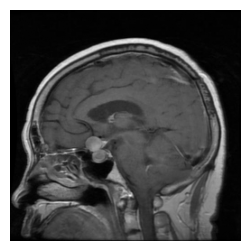

In [3]:
random_index = np.random.randint(0, len(x_test))
random_img = x_test[random_index]
predictions = model.predict(random_img.reshape(1, 256, 256, 3))

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]  

print(f"Predicted label: {predicted_label} \nActual label: {actual_label} \nConfidence: {confidence*100:.2f}%\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()

# **Custom Data Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted label: no_tumor 
Actual label: no_tumor 
Confidence: 100.00%



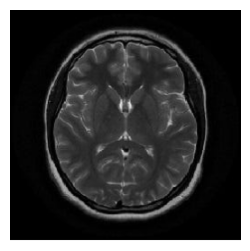

In [2]:
img_path = '/kaggle/input/test-dataset/no_tumor.jpg'
custom_actual_label = 'no_tumor'

custom_img_arr = []
tumor_img = cv2.imread(img_path)
tumor_img = cv2.resize(tumor_img,(256, 256))
custom_img_arr.append(tumor_img)
custom_img_arr = np.array(custom_img_arr)
custom_img_arr = custom_img_arr / 255

custom_pred = model.predict(custom_img_arr.reshape(1, 256, 256, 3))

custom_pred_class = np.argmax(custom_pred)
custom_pred_label = labels[custom_pred_class]
custom_pred_confidence = custom_pred[0][custom_pred_class]

# np.set_printoptions(threshold=20)
# print(t_img)

print(f"Predicted label: {custom_pred_label} \nActual label: {custom_actual_label} \nConfidence: {custom_pred_confidence*100:.2f}%\n")
plt.figure(figsize = (3,3))
plt.imshow(tumor_img)
plt.axis('off')  
plt.show()